<a href="https://colab.research.google.com/github/lucavgn/AML_Project5/blob/main/Distributed_LocalSGD_command_line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%%writefile localSGD.py

import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import argparse
from torch.utils.data import random_split, Subset, DataLoader
from google.colab import files

# Define hyperparameters
# K_values = [2, 4, 8]
# J_values = [4, 8, 16, 32, 64]
num_epochs = 150
base_learning_rate = 1e-2
momentum = 0.9
weight_decay = 4e-4
warmup_epochs = 5

def compute_mean_std(dataset):
    """Compute the mean and std of CIFAR-100 dataset.

    Args:
        dataset: A dataset derived from `torch.utils.data.Dataset`,
                 such as `cifar100_training_dataset` or `cifar100_test_dataset`.

    Returns:
        A tuple containing (mean, std) for the entire dataset.
    """

    # Extract images and labels
    data_r = np.stack([np.array(dataset[i][0])[:, :, 0] for i in range(len(dataset))])
    data_g = np.stack([np.array(dataset[i][0])[:, :, 1] for i in range(len(dataset))])
    data_b = np.stack([np.array(dataset[i][0])[:, :, 2] for i in range(len(dataset))])

    # Compute mean and std
    mean = np.mean(data_r), np.mean(data_g), np.mean(data_b)
    std = np.std(data_r), np.std(data_g), np.std(data_b)

    return mean, std

class LRScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, base_lr, K, warmup_epochs, total_epochs, verbose=False):
        """
        Args:
            optimizer: SGD
            base_lr: Base learning rate for the reference batch size.
            K: Number of workers.
            warmup_epochs: Number of warmup epochs.
            total_epochs: Total number of epochs.
            verbose: Whether to print LR updates.
        """
        self.base_lr = base_lr
        self.K = K
        self.scaled_lr = base_lr * K
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.verbose = verbose
        super(LRScheduler, self).__init__(optimizer)

    def get_lr(self):
        epoch = self.last_epoch
        if epoch < self.warmup_epochs:
            # Linear warmup scaling
            warmup_factor = (epoch + 1) / self.warmup_epochs
            return [warmup_factor * self.scaled_lr for _ in self.optimizer.param_groups]
        else:
            # polynomially decaying learning rate of ηt = η0×(1−t/T)
            if epoch == self.warmup_epochs:
                print(f"Warmup phase completed at epoch {epoch}. Switching to polynomial decay learning rate.")
            return [self.scaled_lr * ( 1 - ( (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs))) for _ in self.optimizer.param_groups]


# Define LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(384, 192)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# Command-line arguments
parser = argparse.ArgumentParser(description='Train with Local SGD')
parser.add_argument('--k', type=int, default=2, help='choose a K value for local SGD: [2, 4, 8]')
parser.add_argument('--j', type=int, default=4, help='choose a J value for local SGD: [4, 8, 16, 32, 64]')
args = parser.parse_args()
K = args.k
J = args.j
print(f"Training with K={K}, J={J}")

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42) # Set the seed for reproducibility
torch.cuda.manual_seed_all(42) # Set the seed for reproducibility on GPU

# use the same mean and std to add consistency to all datasets
data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
mean, std = compute_mean_std(data)

# Load and split CIFAR-100 dataset
train_transform = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)

# Shard the training set
shard_size = len(trainset) // K
shards = [Subset(trainset, range(i * shard_size, (i + 1) * shard_size)) for i in range(K)]

# Batch size
batch_size = shard_size // J

# Test set
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


# Scale the learning rate by k
learning_rate = base_learning_rate * K
print(f"Base learning rate: {learning_rate:.5f}")

# Initialize local models, optimizers and scheduler
nets = [LeNet5().to(device) for _ in range(K)]

with torch.no_grad():
    for net in nets[1:]:  # Skip nets[0] because it's the reference model
        for param_target, param_source in zip(net.parameters(), nets[0].parameters()):
            param_target.data.copy_(param_source.data)

optimizers = [optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay) for net in nets]
schedulers = [LRScheduler(
    optimizer = optimizer,
    base_lr = base_learning_rate,
    K = K,
    warmup_epochs = warmup_epochs,
    total_epochs = num_epochs,
    verbose = True) for optimizer in optimizers]

criterion = nn.CrossEntropyLoss()

# Initialize storage for train losses and accuracies for each worker
train_losses_per_worker = [[] for _ in range(K)]
train_accuracies_per_worker = [[] for _ in range(K)]

# Initialize test losses and accuracies for test set
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # print(f"Epoch {epoch + 1}/{num_epochs}")

    # Sequentially train each worker to simulate a distributed environment
    for k in range(K):
        shard_loader = DataLoader(shards[k], batch_size=batch_size, shuffle=True)

        nets[k].train()
        correct_train, total_train, train_loss = 0, 0, 0.0
        for images, labels in shard_loader:
            images, labels = images.to(device), labels.to(device)  # Move to device
            optimizers[k].zero_grad()
            outputs = nets[k](images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizers[k].step()
            # Calculate train loss and accuracy
            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
        # Store train loss and accuracy for this worker
        train_loss /= len(shard_loader.dataset)
        train_losses_per_worker[k].append(train_loss)
        train_accuracy = 100. * correct_train / total_train
        train_accuracies_per_worker[k].append(train_accuracy)

    # Perform model synchronization
    with torch.no_grad():
        global_parameters = [torch.zeros_like(param) for param in nets[0].parameters()]  # Start with the first worker
        for net in nets:
            for global_param, local_param in zip(global_parameters, net.parameters()):
                global_param += local_param
        for global_param in global_parameters:
            global_param /= K
        # Update each worker model with the global parameters
        for net in nets:
            for local_param, global_param in zip(net.parameters(), global_parameters):
                local_param.data.copy_(global_param)

    # Update lr for each scheduler
    for scheduler in schedulers:
        scheduler.step()

    # Final Evaluation on Test Set
    global_model = nets[0] # all models are synchronized
    global_model.eval()
    # Test
    correct_test, total_test, test_loss = 0, 0, 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = global_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()
    test_loss /= len(testloader)
    test_losses.append(test_loss)
    test_accuracy = 100. * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    for k in range(K):
        print(f"    Worker {k}: Train Loss: {train_losses_per_worker[k][-1]:.4f}, Train Accuracy: {train_accuracies_per_worker[k][-1]:.2f}%")

# Plot results
# Plot Train Loss for Each Worker
plt.figure(figsize=(8, 6))
for k in range(K):
    plt.plot(train_losses_per_worker[k], label=f'Worker {k} Train Loss')
plt.title('Train Loss per Worker')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('train_loss_per_worker.png')
plt.show()

# Plot Train Accuracy for Each Worker
plt.figure(figsize=(8, 6))
for k in range(K):
    plt.plot(train_accuracies_per_worker[k], label=f'Worker {k} Train Accuracy')
plt.title('Train Accuracy per Worker')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('train_accuracy_per_worker.png')
plt.show()

# Plot Test Loss
plt.figure(figsize=(6, 4))
plt.plot(test_losses, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('test_loss.png')
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(6, 4))
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('test_accuracy.png')
plt.show()

Overwriting localSGD.py


Training with K=8, J=64
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Base learning rate: 0.08000
Epoch 1/10: Test Loss: 4.5869, Test Accuracy: 1.96%
    Worker 0: Train Loss: 4.6022, Train Accuracy: 1.26%
    Worker 1: Train Loss: 4.6010, Train Accuracy: 1.26%
    Worker 2: Train Loss: 4.6015, Train Accuracy: 1.39%
    Worker 3: Train Loss: 4.5991, Train Accuracy: 1.49%
    Worker 4: Train Loss: 4.6000, Train Accuracy: 1.47%
    Worker 5: Train Loss: 4.5977, Train Accuracy: 1.25%
    Worker 6: Train Loss: 4.6015, Train Accuracy: 1.20%
    Worker 7: Train Loss: 4.6001, Train Accuracy: 1.41%
Epoch 2/10: Test Loss: 4.2150, Test Accuracy: 6.10%
    Worker 0: Train Loss: 4.4762, Train Accuracy: 2.99%
    Worker 1: Train Loss: 4.4638, Train Accuracy: 2.85%
    Worker 2: Train Loss: 4.4668, Train Accuracy: 2.93%
    Worker 3: Train Loss: 4.4669, Train Accuracy: 2.85%
    Worker 4: Train Loss: 4.4555, Train Accuracy: 3.18%
  

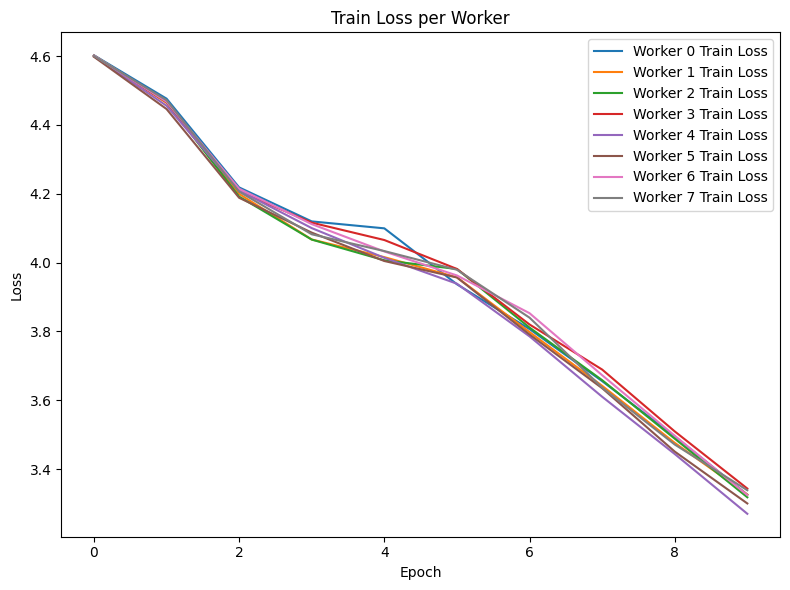

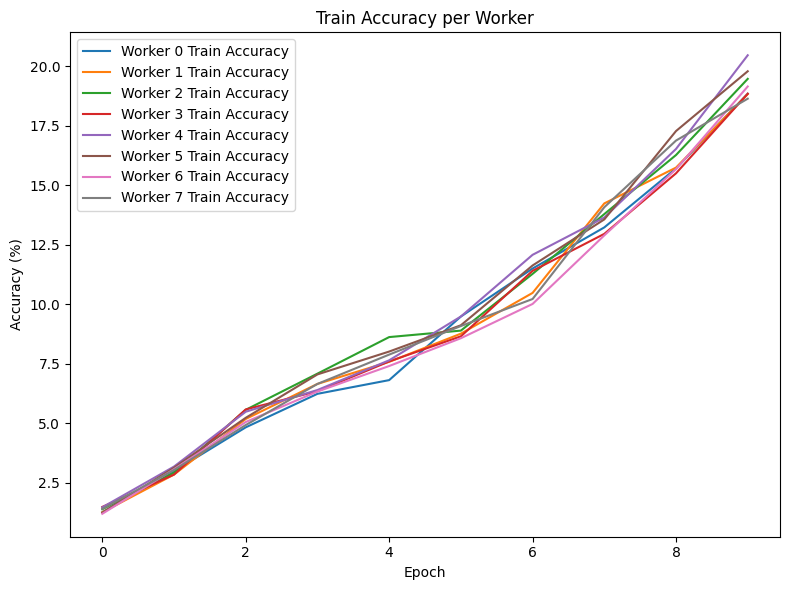

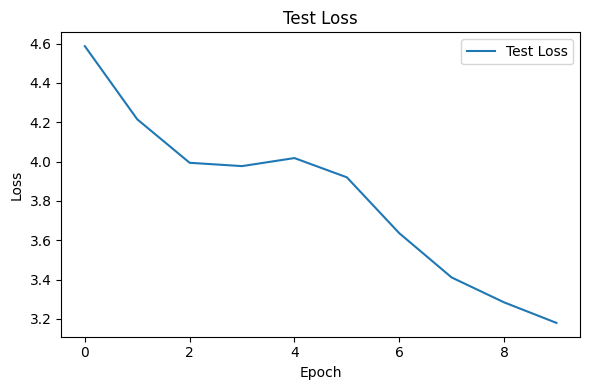

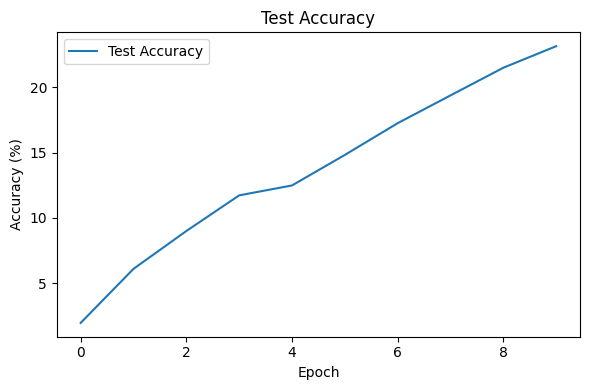

<Figure size 640x480 with 0 Axes>

In [9]:
%run localSGD.py --k 8 --j 64